# **Analyse des cercles sociaux dans la série Game Of Thrones (GoT)**

Travail réalisé en collaboration avec Arthur Mahy (@arthurmahy) et Floriane Ronzon.

## Objectif du projet
Le but est de donner un aperçu de l'analyse d'un réseau social grâce aux algorithmes  **LPAm+ (Label Propagation Algorithm +)** et **DeepWalk**.
Ces algorithmes ont été proposés par **[X. Liu et T. Murata en 2010](https://www.sciencedirect.com/science/article/pii/S0378437109010152)** et **[Bryan Perozzi, Rami Al-Rfou, Steven Skiena en 2014](https://arxiv.org/abs/1403.6652)**.

La détection de communautés dans un réseau social est une manipulation fréquente lors de l'analyse d'un réseau social.

## Import des librairies

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install networkx
!pip install scipy

In [4]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import random
import itertools
import matplotlib.pyplot as plt
import random as rnd
import math
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

## Aperçu du dataset de Game of Thrones (GoT)

In [3]:
path = "data"
file_list = os.listdir(path)

group_list = []
for i in range (0, len(file_list), 3):
    group = tuple(file_list[i:i+3])
    group_list.append(group)

print(f"Liste des fichiers pour les communuatés de GoT : {group_list}")

Liste des fichiers pour les communuatés de GoT : [('got-s1-deaths.csv', 'got-s1-edges.csv', 'got-s1-nodes.csv'), ('got-s2-deaths.csv', 'got-s2-edges.csv', 'got-s2-nodes.csv'), ('got-s3-deaths.csv', 'got-s3-edges.csv', 'got-s3-nodes.csv'), ('got-s4-deaths.csv', 'got-s4-edges.csv', 'got-s4-nodes.csv'), ('got-s5-deaths.csv', 'got-s5-edges.csv', 'got-s5-nodes.csv'), ('got-s6-deaths.csv', 'got-s6-edges.csv', 'got-s6-nodes.csv'), ('got-s7-deaths.csv', 'got-s7-edges.csv', 'got-s7-nodes.csv'), ('got-s8-deaths.csv', 'got-s8-edges.csv', 'got-s8-nodes.csv')]


Chaque saison de GoT comporte trois fichiers : un pour les personnages vus durant la saison ainsi que la communauté à laquelle ils appartiennent **(got-sX-nodes.csv)**, un pour les interactions entre les personnages **(got-sX-edges.csv)** et un pour les personnages morts au cours de la saison **(got-sX-deaths.csv)**.

Les personnages de la saison, leurs interactions et leur communauté permettent de construire un réseau constitué de noeuds labelisés et d'arêtes.
Les noeuds sont les personnages, les labels des noeuds sont leur communauté d'appartenance et les interactions sont les arêtes.

In [12]:
#Exemple pour la saison 1 de GoT
for deaths_file, edges_file, nodes_file in group_list:
    deaths = pd.read_csv(os.path.join(path, deaths_file))
    edges = pd.read_csv(os.path.join(path, edges_file))
    nodes = pd.read_csv(os.path.join(path, nodes_file))
    break

### Aperçu des noeuds du réseau (GoT S1)

In [14]:
nodes

,Id,Name,Community
0,ADDAM_MARBRAND,Addam,Lannister
1,AEGON,Aegon,Night Watch
2,AERYS,Aerys,King's Landing
3,ALLISER_THORNE,Allister,Night Watch
4,ARYA,Arya,King's Landing
...,...,...,...
121,WALDER,Walder,Stark
122,WAYMAR_ROYCE,Waymar,Doomed Night Watch
123,WILL,Will,Doomed Night Watch
124,WINE_MERCHANT,Wine Merchant,Dothraki


Les personnages sont représentés par des ID qui les identifient de manière unique, leur nom et la communauté d'appartenance (ex. Lannister, Stark, Night Watch, etc...).

### Aperçu des arêtes du réseau (GoT S1)

In [15]:
edges

,Source,Target,Weight,Season
0,NED,ROBERT,192,1
1,DAENERYS,JORAH,154,1
2,JON,SAM,121,1
3,LITTLEFINGER,NED,107,1
4,NED,VARYS,96,1
...,...,...,...,...
544,SANSA,STANNIS,2,1
545,STANNIS,TOMARD,2,1
546,THEON,WILL,2,1
547,TYRION,TYSHA,2,1


Les interactions entre les personnages au cours de la saison sont comptées. Le nombre total d'interactions entre 2 personnages constitue le poids de l'arête dans le réseau.
Des interactions sont présents entre des personnages A et B lorsque : 
- Personnage A parle directement après Personnage B,
- Personnage A parle de Personnage B,
- Personnage C parle de Personnage A et Personnage B,
- Personnage A et Personnage B font une action ensemble dans une scène (ex: quittent les lieux, A regarde B, sont assis à une table, etc),
- Personnage A et Personnage B apparaissent ensemble dans une scène.

### Aperçu des morts du réseau (GoT S1)

In [16]:
deaths

,Id,Name,Community
0,BENJEN,Benjen,Night Watch
1,DROGO,Drogo,Dothraki
2,GARED,Gared,Doomed Night Watch
3,HUGH_OF_THE_VALE,Hugh of the Vale,King's Landing
4,JON_ARRYN,Jon Arryn,King's Landing
5,JORY_CASSEL,Jory,King's Landing
6,MAGO,Mago,Dothraki
7,MIRRI_MAZ_DUUR,Mirri Maz Dur,Dothraki
8,MYCAH,Mycah,King's Landing
9,NED,Ned,King's Landing


Les personnages morts durant la saison impactent les communautés.

## Préparation de l'algorithme LPAm+

### Principe de LPAm
Une méthode de clustering basée sur LPAm + est utilisée pour rassembler les personnes dans des communautés selon leurs interactions.

Cet algorithme consiste à propager les étiquettes de communautés dans le réseau selon une règle d'évaluation optimisant la modularité du réseau. Lorsque l'algorithme atteint un optimum local, il regarde s'il est possible de combiner deux communautés pour augmenter la modularité du réseau. L'algorithme choisit toujours la combinaison la plus avantageuse. Si une combinaison est trouvée, la propagation des étiquettes est refaite et l'algorithme poursuit tant qu'il est possible d'améliorer la modularité.

Dans un premier temps, l'ensemble des noeuds du réseau sont initialement étiquetés avec des étiquettes de communautés quelconques. 
L'algorithme LPAm consiste en la mise à jour succesive des étiquettes de communautés de chacun des noeuds jusqu'à atteindre la valeur de modularité de réseau maximale et former des communautés homogènes.

###  Calcul de la modularité du réseau
La modularité $Q$ du réseau est une mesure importante pour l'algorithme : elle permet de savoir si l'algorithme a atteint un optimum local. Elle est définie de la manière suivante : $$ Q=\frac{1}{2m}\sum_{u = 1}^n\sum_{v = 1}^n B_{uv}\delta(l_u,l_v)$$


- $m$ : le nombre d'arêtes
- $n$ : le nombre de noeuds
- $l$ : l'étiquette du noeud
- $u, v$ : des indices de noeuds dans le réseau
- $B$ : la matrice de modularité où chaque élément $B_{uv} = A_{uv} - P_{uv}$
- $A_{uv}$ : vaut 1 si il y une arête entre les noeuds u et v sinon 0
- $P_{uv}$ : la probabilité qu'il y ait une arête entre les noeuds u et v selon le modèle nul. On rappelle que le degré d'un noeud u ($degré(u)$) d'un graphe est le nombre d'arêtes incidentes à ce noeud : $$P_{uv}=\frac{degré(u)*degré(v)}{2m}$$. 
- $\delta(l_u,l_v)$ : delta de Kronecker, vaut 1 si les deux labels sont identiques sinon 0


### Mise à jour des étiquettes de communauté
À chaque itération de l'algorithme, chaque noeud peut voir son étiquette de communauté être modifiée pour maximiser la modularité du réseau entier. Pour un noeud $x$, sa nouvelle étiquette $l_x^{new}$ correspond à l'étiquette pour laquelle la modularité du noeud est maximisée.
$$l_x^{new}=\arg\max_l\sum_{u=1}^n B_{ux}\delta(l_u,l)$$

### Amélioration en LPAm+

Cependant, cette propagation permise par LPAm ne permet d'obtenir, en général, qu'un maximum local de modularité. LPAm+ est une amélioration de LPAm qui  essaye de combiner deux communautés pour augmenter la modularité du réseau et ainsi sortir du maximum local. LPAm+ choisit la combinaison qui augmente le plus la modularité et recommence la propagation d'étiquette jusqu'au prochain optimum local où ilréessaie de combiner des communautés. L'algorithme poursuit jusqu'au maximum global de modularité.

In [7]:
# Classe utilisée pour implémenter l'algorithme de LPAm+
class LPAmPlus:

    def __init__(self, graph):
        """
        graph correspond au graphe sur lequel l'algorithme est appliqué
        """
        self.graph = graph


        """
        Un label (ou communauté) est affecté à chacun des noeuds du jeu de données 
        """
        for i, node in enumerate(self.graph.nodes):
            self.graph.nodes[node]['label'] = i

        """
        labels donne les communautés de chacun des éléments du graphe
        """
        
        self.labels = [i for i in range(0, self.graph.number_of_nodes())]

    """
    Modularité du réseau
        Calcule la nouvelle valeur de modularité du noeud si le label est modifié pour new_label
    """
    def label_evaluation(self, current_node, new_label):
        B = nx.modularity_matrix(self.graph).getA()
        sum = 0
        
        for i, node in enumerate(self.graph.nodes):
            if (new_label == self.graph.nodes[node]['label']) and (node != current_node):
                index_current_node = list(self.graph.nodes).index(current_node)
                sum = sum + B[i][index_current_node]
        return sum
    

    """
    Mise à jour de l'étiquette de communauté
        Le label d'un noeud 
    """

    def update_label(self, current_node):
        old_label = self.graph.nodes[current_node]['label']
        best_l_sum = 0
        potential_labels = [old_label]
        
        for label in self.labels:
            temp_l_sum = self.label_evaluation(current_node, label)
            if (temp_l_sum == best_l_sum):
                potential_labels.append(label)
            elif (temp_l_sum > best_l_sum):
                best_l_sum = temp_l_sum
                potential_labels = [label]
        
        new_label = random.choice(potential_labels)
        self.graph.nodes[current_node]['label'] = new_label
        all_labels_used = [self.graph.nodes[node]['label'] for node in self.graph.nodes]
        

        #Après avoir changé old_label pour new_label, on retire old_label de la liste des labels
        if old_label not in all_labels_used:
            self.labels.remove(old_label)

    """
    Calcule la modularité du réseau
    """

    def modularity(self):
        nb_edges = self.graph.number_of_edges()
        B = nx.modularity_matrix(self.graph).getA()
        Q = 0
        for i, node_i in enumerate(self.graph.nodes):
            label_i = self.graph.nodes[node_i]['label']
            for j, node_j in enumerate(self.graph.nodes):
                label_j = self.graph.nodes[node_j]['label']
                if(label_i == label_j):
                    Q = Q + B[i][j]
        Q = Q*(1/(2*nb_edges))
        return Q
    
    """
    Applique l'algorithme LPAm au réseau
    """

    def LPAm(self):
        current_modularity = -np.Inf
        new_modularity = self.modularity()
        
        while(current_modularity < new_modularity):
            for node in self.graph.nodes:
                self.update_label(node)
                current_modularity = new_modularity
                new_modularity = self.modularity()
   
    """
    Fonction de concaténation des communautés pour quitter les maximums locaux de modularité
    """
    def merge_communities(self):
        merge = False
        real_graph = self.graph.copy() # sauvegarde du graphe
        current_modularity = self.modularity()
        nb_labels = len(self.labels)
        
        for i in range(0, nb_labels-1):
            label_i = self.labels[i]
            for j in range(i+1, nb_labels):
                label_j = self.labels[j]

                # on fusionne les communautés label_j et label_i (tous les label_j sont substitués en label_i)
                for node in self.graph.nodes:
                    if self.graph.nodes[node]['label'] == label_j:
                        self.graph.nodes[node]['label'] = label_i
                new_modularity = self.modularity()
                
                # si la substitution de label_j en label_i augmente la modularité, les communautés peuvent être fusionnées
                if (new_modularity >= current_modularity):
                    current_modularity = new_modularity
                    best_merge = [label_i, label_j]
                    merge = True
                self.graph = real_graph.copy()
        
        # la substitution qui augmente le plus la modularité est effectuée
        if merge :
            for node in self.graph.nodes:
                if (self.graph.nodes[node]['label'] == best_merge[0]):
                    self.graph.nodes[node]['label'] = best_merge[1]
            self.labels.remove(best_merge[0])        
        
        return merge
    
    """
    Applique l'algorithme LPAm+ (LPAM et fusion de communautés)
    """

    def find_communities(self):
        self.LPAm()
        potential_merge = True
        
        # Si une fusion de communautés améliore la modularité, alors elle est effecutée
        while(potential_merge):
            potential_merge = self.merge_communities()

    def get_communities_predictions(self):
        communities_tuples = self.graph.nodes(data = "label")
        communities_list = [item[1] for item in communities_tuples]
        return communities_list

"""
Charge un réseau (noeuds + arêtes) sous format networkx
"""
def load_unweighted_network(node_csv, edge_csv):
    node_csv = pd.read_csv(node_csv)
    edge_csv = pd.read_csv(edge_csv)
    network = nx.Graph()
    for i in range(node_csv.shape[0]):
        network.add_node(node_csv["Id"][i], name=node_csv["Name"][i], community=node_csv["Community"][i])
    for i in range(edge_csv.shape[0]):
        network.add_edge(edge_csv["Source"][i], edge_csv["Target"][i])
    return network

## Fonctions de tests

In [1]:
# def test_load():
#     network = load_unweighted_network("test data/toy-nodes.csv", "test data/toy-edges.csv")
#     nx.draw_networkx(network,font_color='white')
#     plt.show()

# test_load()

In [8]:
# def test_modularity():
#     social_network = load_unweighted_network("test_data/toy-nodes.csv", "test_data/toy-edges.csv")
#     lpam = LPAmPlus(social_network)
#     lpam.labels = [0, 1]
#     for i in [0,1,2,3,4,5,6,7,8,9]:
#         lpam.graph.nodes[i]['label'] = 0
#     for i in [10,11,12,13,14,15]:
#         lpam.graph.nodes[i]['label'] = 1
#     print("Modularity: {}".format(lpam.modularity()))

# test_modularity()

Modularity: 0.4126530612244899


In [9]:
# def test_lpam():
#     social_network = load_unweighted_network("test_data/toy-nodes.csv", "test_data/toy-edges.csv")
#     lpam = LPAmPlus(social_network)
#     lpam.LPAm()
#     print("Modularity: {}\nCommunities: {}".format(lpam.modularity(), lpam.labels))

# test_lpam()

Modularity: 0.39877551020408175
Communities: [3, 5, 8, 11]


In [8]:
# def test_lpam_plus():
#     social_network = load_unweighted_network("test_data/toy-nodes.csv","test_data/toy-edges.csv")
#     lpam = LPAmPlus(social_network)
#     lpam.find_communities()
#     print("Modularity: {:.3f}\nCommunities: {}".format(lpam.modularity(), lpam.labels))

# test_lpam_plus()

Modularity: 0.413
Communities: [8, 11]


## Performances des algorithmes LPAm et LPAm+

Dans cette analyse, le poids des interactions (weights) n'est pas pris en compte dans le réseau. On applique les algorithmes sur chacune des saisons de GoT et on mesure la similarité entre les communautés prédites et les communautés réelles grâce à **l'indice de Rand RI** : $$ RI=\frac{TP+TN}{TP+TN+FP+FN} = \frac{TP+TN}{\binom{n}{2}}$$

- $n$ : le nombre de noeuds
- $TP$ : True Positive soit le nombre de paires d'éléments qui se trouvent dans la même communauté dans la prédiction LPAm+ et également dans les labels réels du dataset,
- $TN$ : True Negative soit le nombre de paires d'éléments qui se trouvent dans des communautés différentes dans la prédiction LPAm+ et également dans les labels réels du dataset,
- $FP$ : False Positive soit le nombre de paires d'éléments qui se trouvent dans la même communauté dans la prédiction LPAm+ mais qui ont des labels réels différents dans le dataset, 
- $FN$ : False Negative soit le nombre de paires d'éléments qui se trouvent dans des communautés différentes dans la prédiction LPAm+ alors qu'ils ont le même label dans le dataset.

### Analyse du dataset

In [36]:
from sklearn.metrics import adjusted_rand_score


"""
Applique l'algorithme LPAm sur une saison de GoT
"""
def lpam_for_one_season(season):
    network_season_got = load_unweighted_network(f"data/got-s{season}-nodes.csv", f"data/got-s{season}-edges.csv")
    lpam = LPAmPlus(network_season_got)
    lpam.LPAm()
    return lpam

"""
Applique l'algorithme LPAm+ sur une saison de GoT
"""
def lpam_plus_for_one_season(season):
    network_season_got = load_unweighted_network(f"data/got-s{season}-nodes.csv", f"data/got-s{season}-edges.csv")
    lpam_plus = LPAmPlus(network_season_got)
    lpam_plus.find_communities()
    return lpam_plus


"""
Calcule le score de similarité entre les communautés prédites par LPAm+ (community) et les les communautés réelles (label)
"""
def calculate_RI(lpam):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for node_i in lpam.graph.nodes(data=True):
        name_i = node_i[0]
        community_i = node_i[1]['community']
        label_i = node_i[1]['label']
        for node_j in lpam.graph.nodes(data=True):
            name_j = node_j[0]
            if name_i != name_j:
                community_j = node_j[1]['community']
                label_j = node_j[1]['label']
                if (community_i == community_j) and (label_i == label_j):
                    TP += 1
                elif (community_i != community_j) and (label_i != label_j):
                    TN += 1
                elif (community_i != community_j) and (label_i == label_j):
                    FP += 1
                else:
                    FN += 1
    RI = (TP + TN)/(TP+TN+FP+FN)
    return [TP, TN, FP, FN], RI

def calculate_ARI(lpam, season):
    labels_true = pd.read_csv(f"data/got-s{season}-nodes.csv")["Community"].tolist()
    labels_predictions = lpam.get_communities_predictions()
    return adjusted_rand_score(labels_true, labels_predictions)

In [23]:
# Les scores RI sont calculés pour chacune des saisons
for season in range(1, 9):
    lpam_season = lpam_for_one_season(season)
    lpam_plus_season = lpam_plus_for_one_season(season)
    _, RI = calculate_RI(lpam_season)
    [TP, TN, FP, FN], RI_plus = calculate_RI(lpam_plus_season)
    
    print(f"SEASON {season}")
    print(f"RI for LPAm = {RI}")
    print("Stats for LPAm+ :")
    print(f"TP = {TP}, TN = {TN}, FP = {FP}, FN = {FN}")
    print(f"RI for LPAm+ = {RI_plus}")
    print("-"*30)

SEASON 1
Stats : 
TP = 3144, TN = 11962, FP = 490, FN = 154
RI for LPAm = 0.8737777777777778
RI for LPAm+ = 0.9591111111111111
------------------------------
SEASON 2
Stats : 
TP = 2704, TN = 13294, FP = 280, FN = 234
RI for LPAm = 0.8648255813953488
RI for LPAm+ = 0.9688711240310077
------------------------------
SEASON 3
Stats : 
TP = 1974, TN = 12190, FP = 786, FN = 56
RI for LPAm = 0.9558843129414901
RI for LPAm+ = 0.9438891110222578
------------------------------
SEASON 4
Stats : 
TP = 4104, TN = 23556, FP = 1118, FN = 292
RI for LPAm = 0.9012727898176814
RI for LPAm+ = 0.9514963880288958
------------------------------
SEASON 5
Stats : 
TP = 2524, TN = 11222, FP = 106, FN = 190
RI for LPAm = 0.8871955561885772
RI for LPAm+ = 0.9789203817120068
------------------------------
SEASON 6
Stats : 
TP = 2556, TN = 16590, FP = 446, FN = 430
RI for LPAm = 0.8959144940565378
RI for LPAm+ = 0.9562481270602338
------------------------------
SEASON 7
Stats : 
TP = 988, TN = 4454, FP = 376, FN 

Le Rand Index montre que LPAm+ obtient systématiquement un meilleur RI que LPAm+ excepté pour la saison 3. Cela signifie que la maximisation de la modulrité peut permettre de créer des communuatés avec plus de précision. De plus, la fusion de communautés permet de se rapprocher plus encore des relations réelles entre les personnages.

On remarque que le RI avec LPAm+ est supérieur à 0,90 pour toutes les saisons exceptées pour les saisons 7 et 8 qui ont respectivement des RI de 0,85 et 0,54. 

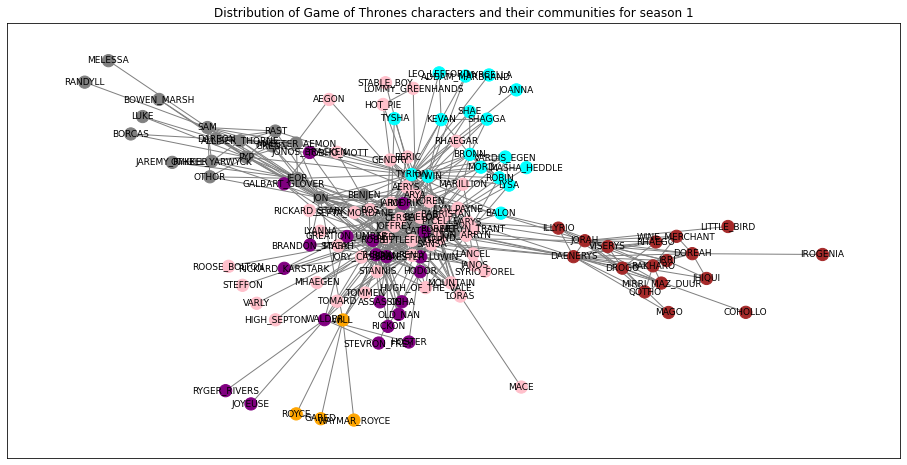

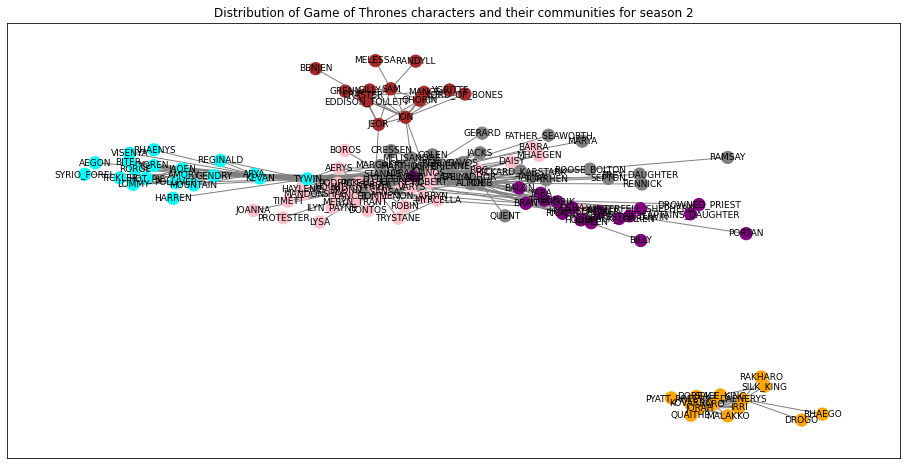

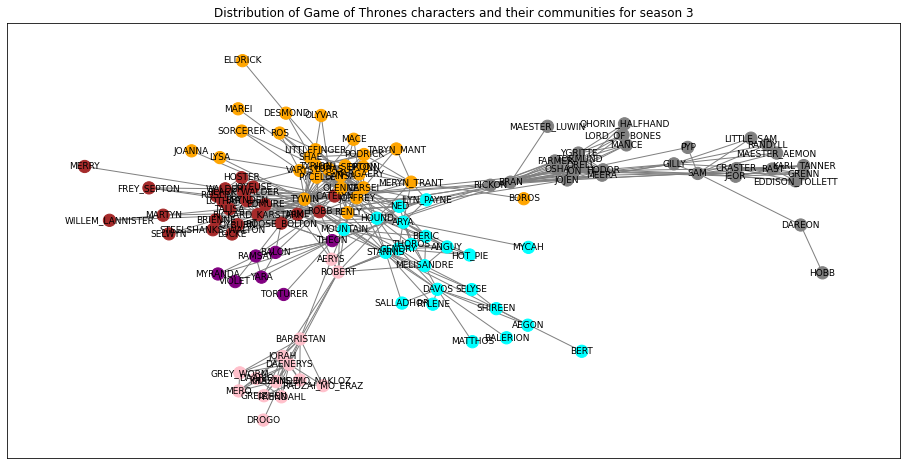

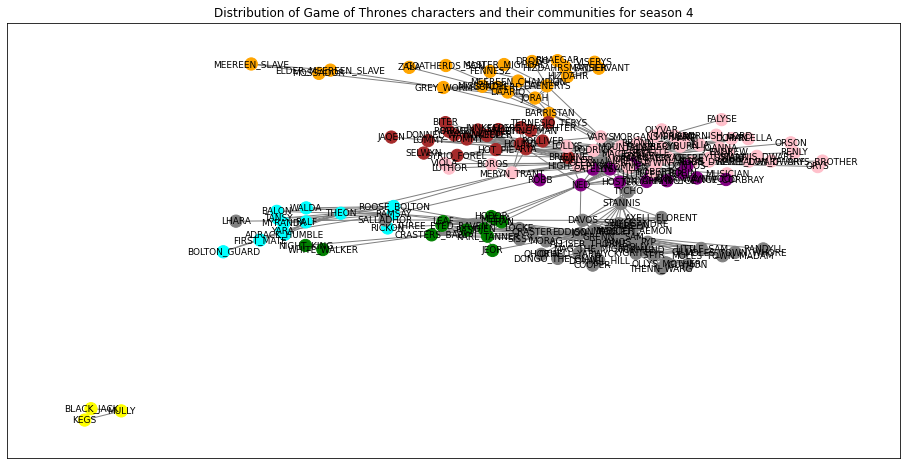

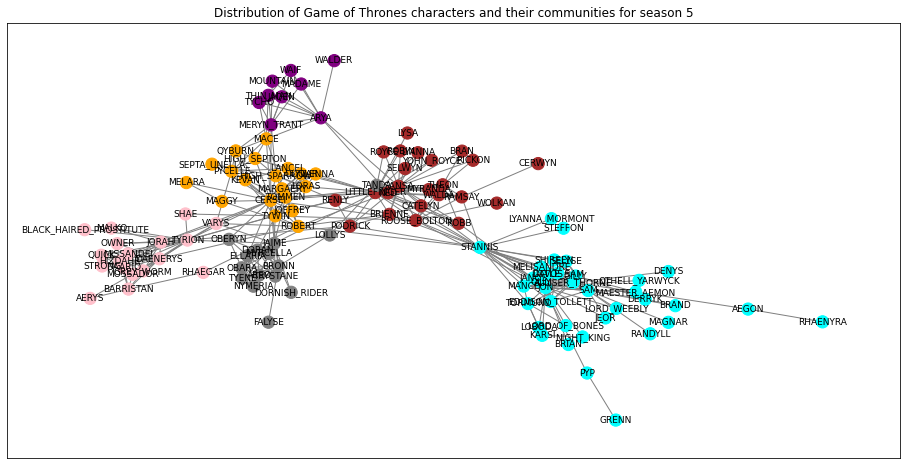

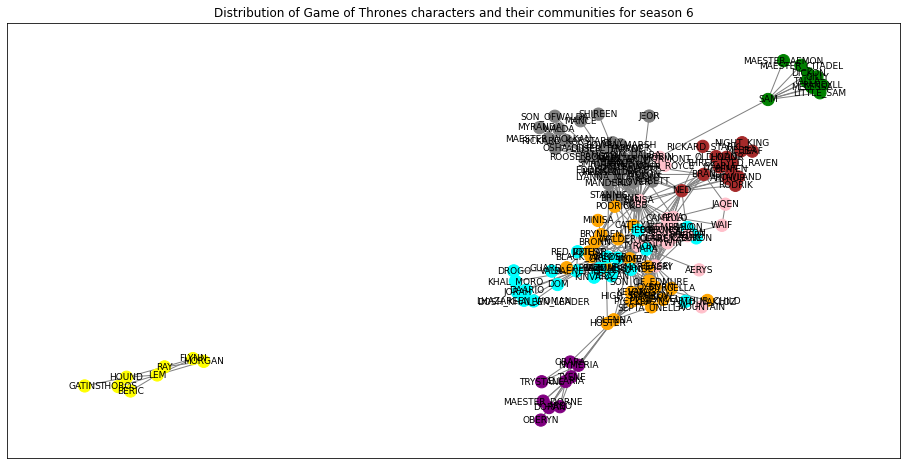

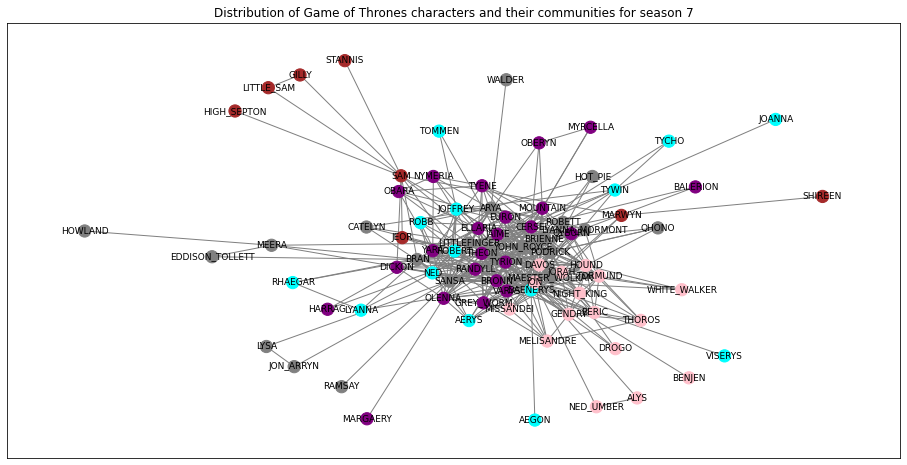

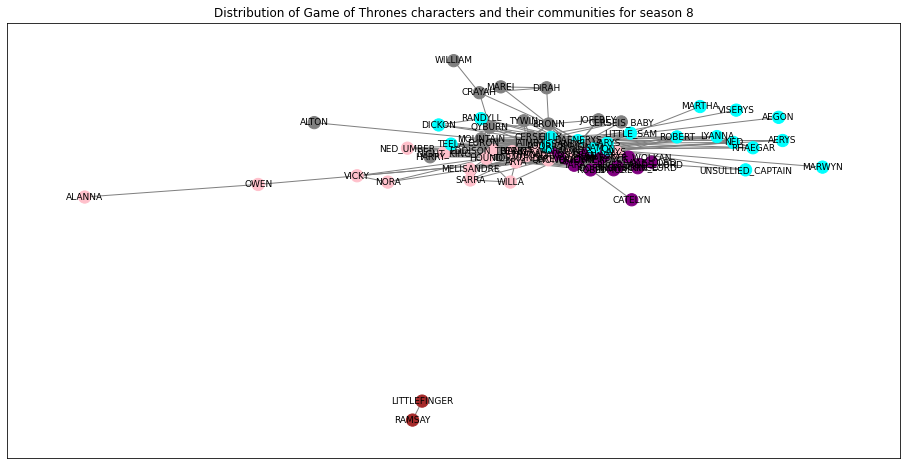

In [35]:
# Etude des communautés créées par l'algorithme LPAm+
for season in range(1, 9):
    network_season_got = load_unweighted_network(f"data/got-s{season}-nodes.csv", f"data/got-s{season}-edges.csv")
    lpam = LPAmPlus(network_season_got)
    lpam.find_communities()
    
    #Affichage des communautés sur un graphe, pour analyser la distribution des personnages et des communautés
    color_choices = ["red", "blue", "green", "yellow", "orange", "brown", "purple", "gray", "pink", "cyan"]
    label_color = {}
    colors = []
    nodes = lpam.graph.nodes
    for node in nodes:
        label = nodes[node]['label']
        if label not in label_color:
            label_color[label] = color_choices.pop()
        colors.append(label_color[label])
    pos = nx.spring_layout(network_season_got)
    fig = plt.figure(figsize=(16,8))
    nx.draw_networkx(network_season_got,pos,node_color=colors,node_size=150,font_size=9,edge_color='gray')
    plt.title(f"Distribution of Game of Thrones characters and their communities for season {season}")
    plt.show()

    fig.savefig(f"figures/figures_GoT_season_{season}_characters_communities.jpg", dpi = 1500)

En traçant la distribution des relations et des communautés, on remarque que plus les communautés sont isolées (autrement dit moins il y a d'interactions entre les différentes communautés), plus le score RI est élevé. E effet, une communauté est facilement identifiable si ses membres n'interagissent qu'entre eux. Par exemple, le score RI le plus élevé est obtenu pour la saison 5, et on voit plusieurs groupes colorés séparés avec peu d'arêtes entre eux sur le graphe. 

Au contraire, pour la saison 8, qui est la saison avec le plus mauvais RI, on remarque que les différentes communautés sont très fortement liées. En effet, la saison finale de GoT est spéciale scénaristiquement parlant, car elle montre l'alliance de communautés ennemies contre une menace commune, les White Walkers. Cela génére des interactions entre des personnages qui sont peu associés ensemble dans les autres saisons.
Il devient alors plus difficile de séparer les communautés car la modularité de ce type de réseau sera très faible. 

L'alliance des communautés s'amorce au cours de la saison 7 et atteint son paroxysme au cours de la saison 8. Cela explique le déclin progressif du RI après la saison 6.

## Étude des personnages influents dans Game of Thrones

Une autre analyse intéressante à faire avec un réseau social est de trouver les personnes influentes du réseau soit les personnes autour desquelles les gens du réseau se regroupent.
Il existe des mesures qui permettent de connaître ces personnes : les mesures de centralité. 
La série Games of Thrones est reconnue pour tuer ses personnages importants. L'objectif est de vérifier si les personnages tués au cours de chacune des saisons font partie des plus influents.

### Mesures de centralité

Une première mesure simple pour trouver l'importance d'un noeud dans un réseau est la **centralité de degré**. Elle se calcule : $$C_{D}(i) = \frac{degré(i)}{n-1}$$

- $i$ : un noeud dans le réseau,
- $n$ : le nombre de noeuds,
- $degré$ : le nombre d'arêtes incidentes au noeud.

Une autre mesure simple pour trouver l'importance d'un noeud dans un réseau est la **centralité de proximité**. Elle se calcule : $$C_{P}(i) = \frac{1}{AvDist(i)}$$

- $i$ : un noeud dans le réseau,
- $AvDist$ : la moyenne de toutes les distances les plus courtes pour atteindre chaque noeud à partir du noeud i.

Une dernière mesure simple pour trouver l'importance d'un noeud dans un réseau est la **centralité d'intermédiarité**. Elle se calcule : $$C_{I}(i) = \frac{\sum_{j<k}f_{jk}(i)}{\binom{n-1}{2}}$$

- $n$ : le nombre de noeuds dans le réseau,
- $i$ : un noeud dans le réseau,
- $j,k$ : deux noeuds dans le réseau excluant i,
- $f_{jk}(i)$: le nombre de chemins les plus courts partant du noeud j vers un noeud k (> j) passant par le noeud i.

In [7]:
"""
Calcule la centralité de degré pour tous les noeuds d'un réseau social_network
"""
def calculate_degree_centrality(social_network):
    n = social_network.number_of_nodes()
    for node in social_network.nodes():
        C = social_network.degree(node) / (n-1)
        social_network.nodes[node]['degree_centrality'] = C

"""
Calcule la centralité de proximité pour tous les noeuds d'un réseau social_network
"""
def calculate_closeness_centrality(social_network):
    n = social_network.number_of_nodes()
    for node in social_network.nodes():
        avg = 0
        for node2 in social_network.nodes():
            avg += (len(nx.shortest_path(social_network, source=node, target=node2)) - 1)
        avg = avg / (n-1)
        C = 1 / avg
        social_network.nodes[node]['closeness_centrality'] = C

"""
Calcule la centralité d'intermédiarité pour tous les noeuds d'un réseau social_network
"""
def calculate_betweenness_centrality(social_network):
    n = social_network.number_of_nodes()
    denom = (n-1)*(n-2)/2
    for id_i in social_network.nodes():
        sum = 0
        for j, id_j in enumerate(social_network.nodes):
            for k, id_k in enumerate(social_network.nodes):
                if (j < k) and (id_i != id_j) and (id_i != id_k):
                    if id_i in nx.shortest_path(social_network, source=id_j, target=id_k):
                        sum += 1
        C = sum / denom
        social_network.nodes[id_i]['betweenness_centrality'] = C

### Fonctions de test des mesures de centralité

In [15]:
# def test_degree_centrality():
#     social_network = load_unweighted_network("test_data/toy-nodes.csv", "test_data/toy-edges.csv")
#     calculate_degree_centrality(social_network)
#     dict_centrality = nx.get_node_attributes(social_network, 'degree_centrality')
#     best_node = max(dict_centrality, key=dict_centrality.get)
#     print("Highest degree centrality node: {} with {}".format(best_node, dict_centrality[best_node]))

# test_degree_centrality()

# def test_closeness_centrality():
#     social_network = load_unweighted_network("test_data/toy-nodes.csv", "test_data/toy-edges.csv")
#     calculate_closeness_centrality(social_network)
#     dict_centrality = nx.get_node_attributes(social_network, 'closeness_centrality')
#     best_node = max(dict_centrality, key=dict_centrality.get)
#     print("Highest closeness centrality node: {} with {}".format(best_node, dict_centrality[best_node]))

# test_closeness_centrality()

# def test_betweenness_centrality():
#     social_network = load_unweighted_network("test_data/toy-nodes.csv", "test_data/toy-edges.csv")
#     calculate_betweenness_centrality(social_network)
#     dict_centrality = nx.get_node_attributes(social_network, 'betweenness_centrality')
#     best_node = max(dict_centrality, key=dict_centrality.get)
#     print("Highest betweenness centrality node: {} with {}".format(best_node, dict_centrality[best_node]))

# test_betweenness_centrality()

Highest closeness centrality node: 7 with 0.5769230769230769


## Analyse des résultats

**Remarque** : les saisons 2, 4, 6 et 8 ne produisent pas un réseau connexe. Pour résoudre le problème, on utilise le plus grand sous-graphe connexe au lieu du réseau entier pour ces saisons. 

In [27]:
"""
    Récupère le plus grand sous graphe connexe d'un réseau
"""
def getLargestConnectedComponent(social_network):
    return max(nx.connected_components(social_network), key=len)

"""
    Retourne le 2e élément d'un tuple
"""
def second(Tuple):
    return Tuple[1]

"""
    Affiche les éléments d'une liste
"""
def Print(liste):
    for i in range(len(liste)):
        print(liste[i])
        
characters_top10_deaths_matrix = np.zeros((3, 8))
# characters_top10_deaths_matrix[i][j] = nombre de personnages dans le top 10 avec la mesure de centralité i sont morts dans la saison j
nb_of_deaths = np.zeros(8)
# nb_of_deaths[j] = nombre de morts dans la saison j

for season in range(1,9):
    print(" ")
    print(f"SEASON {season}: ")
    print(" ")
    edges_path = f"data/got-s{season}-edges.csv"
    nodes_path = f"data/got-s{season}-nodes.csv"
    social_network = load_unweighted_network(nodes_path, edges_path)
    if season==2 or season==4 or season==6 or season==8:
        graphset = getLargestConnectedComponent(social_network)
        social_network = social_network.subgraph(graphset).copy()
    
    print(" Top 10 for degree centrality :")
    calculate_degree_centrality(social_network)
    degree_centrality_list = list(social_network.nodes.data('degree_centrality'))
    degree_centrality_list.sort(key=second, reverse=True)
    degree_centrality_list = degree_centrality_list[:10]
    Print(degree_centrality_list)
    print(" ")

    print(" Top 10 for closeness centrality :")
    calculate_closeness_centrality(social_network)
    closeness_centrality_list = list(social_network.nodes.data('closeness_centrality'))
    closeness_centrality_list.sort(key=second, reverse=True)
    closeness_centrality_list = closeness_centrality_list[:10]
    Print(closeness_centrality_list)
    print(" ")

    print(" Top 10 for betweenness centrality :")
    calculate_betweenness_centrality(social_network)
    betweenness_centrality_list = list(social_network.nodes.data('betweenness_centrality'))
    betweenness_centrality_list.sort(key=second, reverse=True)
    betweenness_centrality_list = betweenness_centrality_list[:10]
    Print(betweenness_centrality_list)
    print(" ")
    
    print(" Deaths of the season :")
    deaths_path = f"data/got-s{season}-deaths.csv"
    deaths_csv = pd.read_csv(deaths_path)
    nb_of_deaths[season-1] = deaths_csv.shape[0]
    for i in range(deaths_csv.shape[0]):
        print(deaths_csv["Id"][i])
    print(" ")
    
    
    print(" Deaths predicted by the top 10 according to the degree centrality metric : ")
    count = 0
    sum_of_rank = 0
    for i in range(10):
        if degree_centrality_list[i][0] in list(deaths_csv["Id"]):
            count += 1
            print(degree_centrality_list[i][0])
    print(" ")
    characters_top10_deaths_matrix[0][season-1] = count

    print(" Deaths predicted by the top 10 according to the closeness centrality metric : ")
    count = 0
    sum_of_rank = 0
    for i in range(10):
        if closeness_centrality_list[i][0] in list(deaths_csv["Id"]):
            count += 1
            print(closeness_centrality_list[i][0])
    print(" ")
    characters_top10_deaths_matrix[1][season-1] = count
    
    print(" Deaths predicted by the top 10 according to the betweenness centrality metric : ")
    count = 0
    sum_of_rank = 0
    for i in range(10):
        if betweenness_centrality_list[i][0] in list(deaths_csv["Id"]):
            count += 1
            print(betweenness_centrality_list[i][0])
    print(" ")
    characters_top10_deaths_matrix[2][season-1] = count
    print("="*40)

 
SEASON 1: 
 
 Top 10 for degree centrality :
('NED', 0.456)
('TYRION', 0.328)
('CATELYN', 0.288)
('ROBERT', 0.288)
('ROBB', 0.24)
('CERSEI', 0.232)
('ARYA', 0.224)
('JOFFREY', 0.216)
('JON', 0.208)
('LITTLEFINGER', 0.208)
 
 Top 10 for closeness centrality :
('NED', 0.6281407035175879)
('ROBERT', 0.5530973451327433)
('CATELYN', 0.5506607929515418)
('TYRION', 0.5434782608695652)
('JON', 0.5186721991701245)
('ROBB', 0.5122950819672131)
('JOFFREY', 0.5102040816326531)
('CERSEI', 0.508130081300813)
('ARYA', 0.5020080321285141)
('JAIME', 0.49800796812749004)
 
 Top 10 for betweenness centrality :
('NED', 0.3881290322580645)
('TYRION', 0.15380645161290324)
('CATELYN', 0.14309677419354838)
('DAENERYS', 0.13380645161290322)
('JON', 0.10761290322580645)
('ROBERT', 0.09935483870967741)
('ARYA', 0.0624516129032258)
('BRAN', 0.056129032258064517)
('ROBB', 0.05212903225806451)
('PYP', 0.05006451612903226)
 
 Deaths of the season :
BENJEN
DROGO
GARED
HUGH_OF_THE_VALE
JON_ARRYN
JORY_CASSEL
MAGO
MIR

### Visualisation des résultats de la prédiction des morts avec les mesures de centralité

In [32]:
centrality_metrics_names = ['Degree centrality correct deaths', 'Closeness centrality correct deaths', 'Betweenness centrality correct deaths']         
season_names = [f"Season {i}" for i in range(1,9)]

deaths_predictions_df = pd.DataFrame(characters_top10_deaths_matrix.astype(int), index=centrality_metrics_names, columns=season_names)
deaths_predictions_df = deaths_predictions_df.T
deaths_predictions_df["Actual number of deaths"] = nb_of_deaths.astype(int)
deaths_predictions_df.head(n=8)

,Degree centrality correct deaths,Closeness centrality correct deaths,Betweenness centrality correct deaths,Actual number of deaths
Season 1,2,2,2,21
Season 2,0,0,0,27
Season 3,2,2,2,18
Season 4,3,2,1,34
Season 5,2,1,2,17
Season 6,1,2,0,41
Season 7,0,0,0,9
Season 8,1,2,4,20


Le tableau de résultats des prédictions se lit de la manière suivante, pour la saison 4 par exemple :
- il y a 3 personnages effectivement morts parmi les 10 personnages ayant les valeurs de centralité de degré les plus élevées,
- il y a 2 personnages effectivement morts parmi les 10 personnages ayant les valeurs de centralité de proximité les plus élevées,
- il y a 1 personnages effectivement morts parmi les 10 personnages ayant les valeurs de centralité d'intermédiarité les plus élevées,
- pourtant, il y a au total 34 morts au cours de la saison.
La première observation est que se limiter au top 10 est insuffisant pour prédire toutes les morts. 
Les 3 métriques semblent se valoir en termes de prédictions de morts (11 morts correctement prédites pour chacune).

En itérant cette lecture pour l'ensemble des saisons, on remarque que les mesures de centralité sont peu corrélées avec les morts de personnages. En considérant les personnages effectuant des interactions avec beaucoup d'autres comme influents, on peut alors dire que les personnages les plus influents ne sont pas toujours tous tués par les scénaristes.

Il y a néanmoins des corrélations non négligeables parmi les morts importantes de la série : Ned Stark dans la saison 1, Robb et Catelyn Stark dans la saison 3, Jeffrey et Oberyn dans la saison 4, Jon Snow et Stannis dans la saison 5, Daenerys et Jaime Lannister dans la saison 8.

##  Prédiction de liens
Une autre analyse intéressante à faire avec un réseau social est la prédiction de liens. En regardant les interactions entre les personnes du réseau, il est possible de déterminer la probabilité qu'un lien apparaisse entre deux personnes dans le réseau. On utilise le modèle DeepWalk pour apprendre des informations sur les interactions et les utiliser afin de prédire de potientielles futures interactions. 

### DeepWalk
Le modèle de DeepWalk est basé sur l'idée de traiter un réseau social comme un texte. On peut ainsi utiliser des techniques d'apprentissage machine pour du traitement de language. C'est un modèle en deux étapes:
- La première étape est de contruire le "dictionnaire" du réseau en explorant le voisinage de chaque noeud.
- La deuxième étape applique l'algorithme SkipGram sur le "dictionnaire" pour apprendre les *embeddings* pertinents. Le réseau est maintenant transformé et prêt à être traité par des techniques de NLP.

In [5]:

"""
Calcule la transformation softmax d'une liste
"""
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


# La classe correspond au modèle DeepWalk
class DeepWalk:
    def __init__(self, graph):
        self.graph = graph

        self.random_walks = []
        self.walk_length = None
        self.n_walk = None

        self.node_index = None
        self.training_data = None

        self.n_neurons = None
        self.epochs = None
        self.embeddings = None
        self.W1 = None
        self.loss = 0
        self.alpha = 0.00001
        self.init = None


    
    """
    Effectue une marche aléatoire à partir d'un noeud et retourne les noeuds visités (la longueur de la marche est définie par self.walk_length)
    """
    def random_walk(self, start_node):
        current_node = start_node
        walk = []
        for i in range (self.walk_length):
            c_n_neighbors = [node for node in self.graph.neighbors(current_node)]
            new_node = rnd.choice(c_n_neighbors)
            walk.append(new_node)
            current_node = new_node
        return walk

    """
    Effectue un nombre n_walk de marches aléatoires de longueurs walk_length pour chaque noeud du réseau et stocke la matrice de marches aléatoires dans self.random_walks
    """
    def build_random_walks_matrix(self, n_walk, walk_length):
        self.n_walk = n_walk
        self.walk_length = walk_length
        for node in self.graph:
            for i in range(self.n_walk):
                self.random_walks.append(self.random_walk(node))
        rnd.shuffle(self.random_walks)


    """
    Convertit la matrice de marches aléatoires en contexte utilisable pour la conversion en embeddings
        Le contexte est un vecteur de 0 et de 1 avec des 1 aux indexes qui correspondent aux voisins du noeud évalué
        La cible (target) est un vecteur one-hot avec un 1 à l'index du noeud évalué
    """
    def create_training(self, window_size):
        self.node_index = list(self.graph.nodes)
        training_data = []
        self.build_random_walks_matrix(self.n_walk, self.walk_length)
        random_walks_matrix = self.random_walks
        for walk in random_walks_matrix:
            for i, node in enumerate(walk):
                target_vector = np.zeros(len(self.node_index))
                context_vector = np.zeros(len(self.node_index))
                target_vector[self.node_index.index(node)] = 1

                for j in range(max(0, i-window_size), min(len(walk),i+window_size)):
                    context_vector[self.node_index.index(walk[j])] += 1
          
                training_data.append([target_vector, context_vector])
        
        self.training_data = training_data


    """
    Effectue la conversion du contexte en embeddings
    """
    def neural_network(self, epochs, n_neurons):
        self.n_neurons = n_neurons
        self.epochs = epochs
        self.init = math.sqrt(6 /
                              (self.graph.number_of_nodes() + self.n_neurons))
        self.embeddings = np.random.uniform(
            -self.init, self.init,
            (self.graph.number_of_nodes(), self.n_neurons))
        self.W1 = np.random.uniform(
            -self.init, self.init,
            (self.n_neurons, self.graph.number_of_nodes()))

        for x in range(1, epochs):
            self.loss = []
            for x_data, y_data in tqdm.tqdm(self.training_data):
                self._feed_forward(x_data)
                self._backpropagate(x_data, y_data)
                C = 0
                sub_loss = 0
                for m in range(self.graph.number_of_nodes()):
                    if y_data[m]:
                        sub_loss += -1 * self.u[m][0]
                        C += 1
                sub_loss += C * np.log(np.sum(np.exp(self.u)))
                self.loss.append(sub_loss)
            self.loss = np.mean(self.loss)
            print("epoch ", x, " loss = ", self.loss)
            self.alpha *= 1 / (1 + self.alpha * x)

    """
    Exécute l'algorithme SkipGram pour générer les embeddings à partir du réseau
    """
    def skip_gram(self, window_size, epochs, n_neurons):
        self.create_training(window_size)
        self.neural_network(epochs, n_neurons)
        return self.embeddings, self.W1


    """
    Fonction de produit matriciel pour la propagation avant 
    """
    def _feed_forward(self, X):
        self.h = np.dot(self.embeddings.T, X).reshape(self.n_neurons, 1)
        self.u = np.dot(self.W1.T, self.h)
        self.y = softmax(self.u)
        return self.y

    """
    Fonction de propagation arrière pour actualiser les poids des embeddings
    """
    def _backpropagate(self, x, t):
        e = self.y - np.asarray(t).reshape(self.graph.number_of_nodes(), 1)
        dLdW1 = np.dot(self.h, e.T)
        X = np.array(x).reshape(self.graph.number_of_nodes(), 1)
        dLdW = np.dot(X, np.dot(self.W1, e).T)
        self.W1 = self.W1 - self.alpha * dLdW1
        self.embeddings = self.embeddings - self.alpha * dLdW



La première étape du modèle DeepWalk consiste à parcourir de manière aléatoire le réseau pour se construire un "dictionnaire" du réseau. La marche aléatoire dépend de deux paramètres: le nombre de marche(n_walk) et la longueur de la marche(walk_length). La longeur de la marche correspond au nombre de noeuds dans la marche. En explorant le graphe, le modèle se construit des "contextes" à partir des liens entres les noeuds. On peut considérer cela comme des phrases ou des extraits de phrases dans un texte. Deux noeuds sont similaires si leur contexte le sont aussi.
 

On peut désormais utiliser les embeddings générés pour entraîner un modèle qui sera capable de prédire les liens entre noeuds du réseau.

Pour tester l'efficacité de l'algorithme, on enlève un lien fort, un lien moyen et un lien faible d'un noeud du réseau. On utilise le `weight` pour déterminer la force du lien. 
Après avoir enlevé les 3 liens, on applique DeepWalk sur le graphe résultant et on utilise les **embeddings** pour prédire des liens sur le noeud. 
Nous voulons voir si le modèle est capable de retrouver ces 3 liens pour le noeud.

### Résultats

In [8]:
#On utilise les datasets de la première saison :
network = load_unweighted_network("data/got-s1-nodes.csv", "data/got-s1-edges.csv")
deepwalk = DeepWalk(network)
deepwalk.n_walk = 15
deepwalk.walk_length = 10
deepwalk.alpha = 1e-5

embeddings, w1 = deepwalk.skip_gram(3, 30, 100)

100%|██████████| 18900/18900 [00:01<00:00, 12610.10it/s]


epoch  1  loss =  22.37156991704912


100%|██████████| 18900/18900 [00:01<00:00, 12284.44it/s]


epoch  2  loss =  22.36270757278872


100%|██████████| 18900/18900 [00:01<00:00, 12489.00it/s]


epoch  3  loss =  22.35384611563472


100%|██████████| 18900/18900 [00:01<00:00, 12754.68it/s]


epoch  4  loss =  22.34498160856976


100%|██████████| 18900/18900 [00:01<00:00, 12794.40it/s]


epoch  5  loss =  22.33611011882804


100%|██████████| 18900/18900 [00:01<00:00, 13070.26it/s]


epoch  6  loss =  22.327227714903515


100%|██████████| 18900/18900 [00:01<00:00, 13153.82it/s]


epoch  7  loss =  22.318330463609932


100%|██████████| 18900/18900 [00:01<00:00, 13139.56it/s]


epoch  8  loss =  22.309414427193484


100%|██████████| 18900/18900 [00:01<00:00, 13159.48it/s]


epoch  9  loss =  22.300475660499213


100%|██████████| 18900/18900 [00:01<00:00, 13097.54it/s]


epoch  10  loss =  22.291510208192935


100%|██████████| 18900/18900 [00:01<00:00, 13304.97it/s]


epoch  11  loss =  22.282514102040867


100%|██████████| 18900/18900 [00:01<00:00, 13297.27it/s]


epoch  12  loss =  22.273483358249745


100%|██████████| 18900/18900 [00:01<00:00, 13472.28it/s]


epoch  13  loss =  22.26441397487091


100%|██████████| 18900/18900 [00:01<00:00, 13409.16it/s]


epoch  14  loss =  22.25530192927242


100%|██████████| 18900/18900 [00:01<00:00, 13350.77it/s]


epoch  15  loss =  22.246143175684214


100%|██████████| 18900/18900 [00:01<00:00, 13149.38it/s]


epoch  16  loss =  22.236933642821846


100%|██████████| 18900/18900 [00:01<00:00, 13367.87it/s]


epoch  17  loss =  22.227669231595716


100%|██████████| 18900/18900 [00:01<00:00, 13501.00it/s]


epoch  18  loss =  22.21834581291324


100%|██████████| 18900/18900 [00:01<00:00, 13405.33it/s]


epoch  19  loss =  22.208959225582944


100%|██████████| 18900/18900 [00:01<00:00, 13578.58it/s]


epoch  20  loss =  22.199505274330523


100%|██████████| 18900/18900 [00:01<00:00, 13483.90it/s]


epoch  21  loss =  22.18997972793826


100%|██████████| 18900/18900 [00:01<00:00, 12764.76it/s]


epoch  22  loss =  22.180378317520887


100%|██████████| 18900/18900 [00:01<00:00, 13162.97it/s]


epoch  23  loss =  22.170696734952674


100%|██████████| 18900/18900 [00:01<00:00, 13313.88it/s]


epoch  24  loss =  22.16093063146222


100%|██████████| 18900/18900 [00:01<00:00, 13145.52it/s]


epoch  25  loss =  22.1510756164139


100%|██████████| 18900/18900 [00:01<00:00, 13376.14it/s]


epoch  26  loss =  22.141127256296972


100%|██████████| 18900/18900 [00:01<00:00, 13406.58it/s]


epoch  27  loss =  22.131081073946152


100%|██████████| 18900/18900 [00:01<00:00, 13440.05it/s]


epoch  28  loss =  22.12093254802041


100%|██████████| 18900/18900 [00:01<00:00, 13538.91it/s]

epoch  29  loss =  22.11067711276993


In [107]:
nodes_csv_s1 = pd.read_csv("data/got-s1-nodes.csv")
edges_csv_s1 = pd.read_csv("data/got-s1-edges.csv")

"""
Retourne les paires liées au personnage spécifié avec character_id et les personnages n'ayant aucun lien avec le personnage spécifié avec character_id
"""
def get_links_with_character(nodes_csv, edges_csv, character_id):
    links = edges_csv[(edges_csv.Source == character_id) | (edges_csv.Target == character_id)]
    linked_characters = links[["Source","Target", "Weight"]]
    all_characters = nodes_csv["Id"]
    not_linked_characters = [character for character in all_characters if character not in linked_characters.Source.tolist() + linked_characters.Target.tolist()]
    return linked_characters, not_linked_characters

In [108]:
get_links_with_character(nodes_csv_s1, edges_csv_s1, "JON")

(             Source          Target  Weight
 2               JON             SAM     121
 19             JEOR             JON      60
 30              JON          TYRION      45
 34              JON             PYP      42
 44           BENJEN             JON      33
 58              JON             NED      29
 64              JON   MAESTER_AEMON      28
 72              JON            ROBB      25
 75            GRENN             JON      24
 82   ALLISER_THORNE             JON      20
 83             ARYA             JON      20
 86             BRAN             JON      19
 117         CATELYN             JON      14
 160           JAIME             JON      10
 212             JON            RAST       7
 213             JON           THEON       7
 269             JON  OTHELL_YARWYCK       5
 270             JON           OTHOR       5
 300          DAREON             JON       4
 354          CERSEI             JON       3
 379             JON          ROBERT       3
 380      

In [141]:
# liste de toutes les paires du réseau
links_pairs = list(itertools.combinations(deepwalk.node_index, 2))
print(f"Total number of links : {len(links_pairs)}")

# On choisit le personnage "JON" et on retire des liens avec d'autres personnages pour l'entraînement
# Lien fort avec Jon : JON-SAM-121 
links_pairs.remove(("JON", "SAM"))
# Lien moyen avec Jon : JON-TYRION-45
links_pairs.remove(("JON", "TYRION"))
# Lien faible avec Jon : CATELYN-JON-14 
links_pairs.remove(("CATELYN", "JON"))

print(f"Total number of links after deleting Jon's links : {len(links_pairs)}")

"""
Crée un jeu de données à partir des liens du graphe
"""
def create_links_data(links_pairs):
    X0 = []
    X1 = []

    # Formation des vecteurs X et y :
    for pair in links_pairs:
        if deepwalk.graph.has_edge(pair[0], pair[1]):
            # s'il y a un lien entre les deux noeuds
            X1.append(np.array([deepwalk.embeddings[deepwalk.node_index.index(pair[0])], deepwalk.embeddings[deepwalk.node_index.index(pair[1])]]))
        else:
            X0.append(np.array([deepwalk.embeddings[deepwalk.node_index.index(pair[0])], deepwalk.embeddings[deepwalk.node_index.index(pair[1])]]))

    X0 = np.array(X0)
    X1 = np.array(X1)

    X0_part = X0[np.random.randint(X0.shape[0], size=1500), :]
   
    X1_part = X1[np.random.randint(X1.shape[0], size=750), :]
    print(f"Number of linked pairs : {X1_part.shape[0]}")
    print(f"Number of unlinked pairs : {X0_part.shape[0]}")

    y0 = np.zeros(X0_part.shape[0])
    y1 = np.ones(X1_part.shape[0])

    X = np.concatenate([X0_part, X1_part])
    y = np.concatenate([y0,y1])
    return X, y

Total number of links : 7875
Total number of links after deleting Jon's links : 7872


Pour l'entraînement, on construit un vecteur contenant les contextes (embeddings) d'une paire de noeud et un label pour indiquer si la paire est liée (label = 1) ou non liée (label = 0).
Chaque noeud a un contexte de 100 valeurs flottantes. Ainsi, le vecteur d'une paire est de taille 200.
La matrice X contient les vecteurs pour une sélection de paires et la matrice ′y′ contient le label correspondant. 

In [142]:
X, y = create_links_data(links_pairs)
# On splite en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=42)

print("Data split :")

# On change la forme de la matrice 
X_train = np.array(X_train).reshape(-1, 200)
X_test = np.array(X_test).reshape(-1, 200)
y_train = np.array(y_train)
y_test = np.array(y_test)
print(f"X_train : {X_train.shape}\ny_train : {y_train.shape}\nX_test : {X_test.shape}\ny_test : {y_test.shape}")

Number of linked pairs : 750
Number of unlinked pairs : 1500
Data split :
X_train : (1800, 200)
y_train : (1800,)
X_test : (450, 200)
y_test : (450,)


In [144]:
# Affichage du report :
RF = RandomForestClassifier(class_weight='balanced', random_state=42)

RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

print("Random Forest model accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Random Forest model accuracy : 0.9111111111111111
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93       301
         1.0       0.88      0.85      0.86       149

    accuracy                           0.91       450
   macro avg       0.90      0.90      0.90       450
weighted avg       0.91      0.91      0.91       450



In [146]:
# On regarde si le modèle peut prédire correctement les liens qu'on a supprimé précédemment
print("Prediction strong link between Jon and Sam:", RF.predict(np.array([deepwalk.embeddings[deepwalk.node_index.index("JON")], deepwalk.embeddings[deepwalk.node_index.index("SAM")]]).reshape(1,-1)))
print("Prediction medium link between Jon and Tyrion:", RF.predict(np.array([deepwalk.embeddings[deepwalk.node_index.index("JON")], deepwalk.embeddings[deepwalk.node_index.index("TYRION")]]).reshape(1,-1)))
print("Prediction weak link between Jon and Catelyn:", RF.predict(np.array([deepwalk.embeddings[deepwalk.node_index.index("JON")], deepwalk.embeddings[deepwalk.node_index.index("CATELYN")]]).reshape(1,-1)))
print("="*50)
print("Prediction of no link between Jon and Daenerys:", RF.predict(np.array([deepwalk.embeddings[deepwalk.node_index.index("JON")], deepwalk.embeddings[deepwalk.node_index.index("DAENERYS")]]).reshape(1,-1)))
print("Prediction of no link between Jon and Jorah:", RF.predict(np.array([deepwalk.embeddings[deepwalk.node_index.index("JON")], deepwalk.embeddings[deepwalk.node_index.index("JORAH")]]).reshape(1,-1)))
print("Prediction of no link between Jon and Mycah:", RF.predict(np.array([deepwalk.embeddings[deepwalk.node_index.index("JON")], deepwalk.embeddings[deepwalk.node_index.index("MYCAH")]]).reshape(1,-1)))

Prediction strong link between Jon and Sam: [1.]
Prediction medium link between Jon and Tyrion: [1.]
Prediction weak link between Jon and Catelyn: [1.]
Prediction of no link between Jon and Daenerys: [0.]
Prediction of no link between Jon and Jorah: [0.]
Prediction of no link between Jon and Mycah: [0.]


### Analyse

Le modèle Random Forest permet d'avoir une précision supérieure à 90 % sur la prédiction des liens.

Ici, on a un gros déséquilibre entre les classes des données (546 paires liées vs 7326 paires non liées). Les données sont rééquilibrées en effectuant une sélection d'un nombre semblable de paires liées et non liées. Dans notre cas, on sélectionne au hasard 1500 paires non liées et 750 liées. 
Après rééquilibrage des données, le modèle parvient à prédire les liens fort, moyen et faible de JON et prédit une absence de liens avec Daenerys, Jorah et Micah. 

### Conclusion

L'algorithme DeepWalk permet d'analyser aisément les interactions entre les personnages et prédire les liens entre eux. Une future étude qui pourrait être intéressante serait d'étudier les prédictions entre les liens des personnages d'une saison à l'autre et d'observer si DeepWalk peut prédire le scénario des saisons suivantes.